#### Import Package

In [40]:
import pandas as pd
import numpy as np
import quantstats as qs

from sklearn.preprocessing import MinMaxScaler

from core.system import *
from core.operation import *

import warnings

warnings.filterwarnings('ignore')

#### Param

In [2]:
live = True
start = '2005-01-01'
current_date = (date.today()).strftime('%Y-%m-%d')

#### Function

In [278]:
def load_data(ticker):
    # Load Data
    tic = pd.read_parquet(get_parquet(live) / 'data_ticker.parquet.brotli')
    permno = tic.loc[tic.ticker == ticker].index.get_level_values('permno').unique()[0]
    print(f"{ticker} permno: {permno}\n\n")
    ohclv = pd.read_parquet(get_parquet(live) / 'data_price.parquet.brotli')
    ohclv = get_stock_data(ohclv, permno)
    fundq = pd.read_parquet(get_parquet(live) / 'data_fund_raw_q.parquet.brotli')
    fundq = get_stock_data(fundq, permno)
    return ohclv, fundq

def value(fundq):
    # Create
    fundq = fundq.ffill()
    fundq['current_ratio'] = fundq['atq'] / fundq['lctq']
    fundq['cash_ratio'] = fundq['cheq'] / fundq['lctq']
    fundq['debt_equity_ratio'] = fundq['ltq'] / fundq['ceqq']
    fundq['return_on_assets'] = fundq['niq'] / fundq['atq']
    fundq['return_on_equity'] = fundq['niq'] / fundq['ceqq']
    fundq['gross_profit_margin'] = (fundq['saleq'] - fundq['cogsq']) / fundq['saleq']
    fundq['net_profit_margin'] = fundq['niq'] / fundq['saleq']
    fundq['asset_turnover'] = fundq['saleq'] / fundq['atq']
    fundq['inventory_turnover'] = fundq['cogsq'] / fundq['invtq']
    fundq['payable_turnover'] = fundq['cogsq'] / fundq['apq']
    fundq['book_to_market'] = fundq['ceqq'] / (fundq['prccq'] * fundq['cshoq'])
    fundq['price_to_earnings'] = fundq['prccq'] / (fundq['niq'] / fundq['cshoq'])
    fundq['ev_to_ebitda'] = (fundq['ltq'] + fundq['ceqq'] + (fundq['prccq'] * fundq['cshoq'])) / (fundq['niq'] + fundq['dpq'] + fundq['xintq'])
    fundq['debt_ratio'] = fundq['ltq'] / fundq['atq']
    fundq['roic'] = fundq['niq'] / (fundq['ceqq'] + fundq['ltq'])
    fundq['financial_leverage'] = fundq['atq'] / fundq['ceqq']
    fundq['net_margin'] = fundq['niq'] / fundq['revtq']
    fundq['interest_coverage_ratio'] = fundq['piq'] / fundq['xintq']
    fundq = fundq.replace([np.inf, -np.inf], np.nan)
    fundq = fundq.ffill()
    return fundq

def analysis(ohclv, fundq, style, window, split_date):
    # Data
    analysis = ohclv.copy(deep=True)
    analysis = analysis.join(fundq[style])
    analysis = analysis.ffill()

    # Resample to monthly
    analysis = analysis.reset_index(level=0)
    analysis = analysis.groupby([analysis.index.to_period('M'), 'permno']).nth(-1).reset_index().set_index(['permno', 'date'])
    
    # Return
    ret = f'RET_{window:02}'
    analysis = create_return(analysis, [window])
    scaler = MinMaxScaler()
    col_to_scale = [ret, style]
    col_change = [f'{ret}_scale', f'{style}_scale']
    analysis[col_change] = scaler.fit_transform(analysis[col_to_scale])
    analysis[col_change].plot(figsize=(30, 5))
    copy = analysis.copy(deep=True)
    plt.show()

    # Correlation
    pre_2016 = set_timeframe(analysis[[f'{style}_scale', f'{ret}_scale']], '2005-01-01', split_date)
    post_2016 = set_timeframe(analysis[[f'{style}_scale', f'{ret}_scale']], split_date, '2024-01-01')
    corr_pre = pre_2016[[f'{style}_scale', f'{ret}_scale']].corr()
    corr_post = post_2016[[f'{style}_scale', f'{ret}_scale']].corr()
    corr_total = analysis[[f'{style}_scale', f'{ret}_scale']].corr()
    print(f"\n\n{corr_pre} \n\n{corr_post} \n\n{corr_total}")
    return copy

#### Analysis

GOOGL permno: 90319




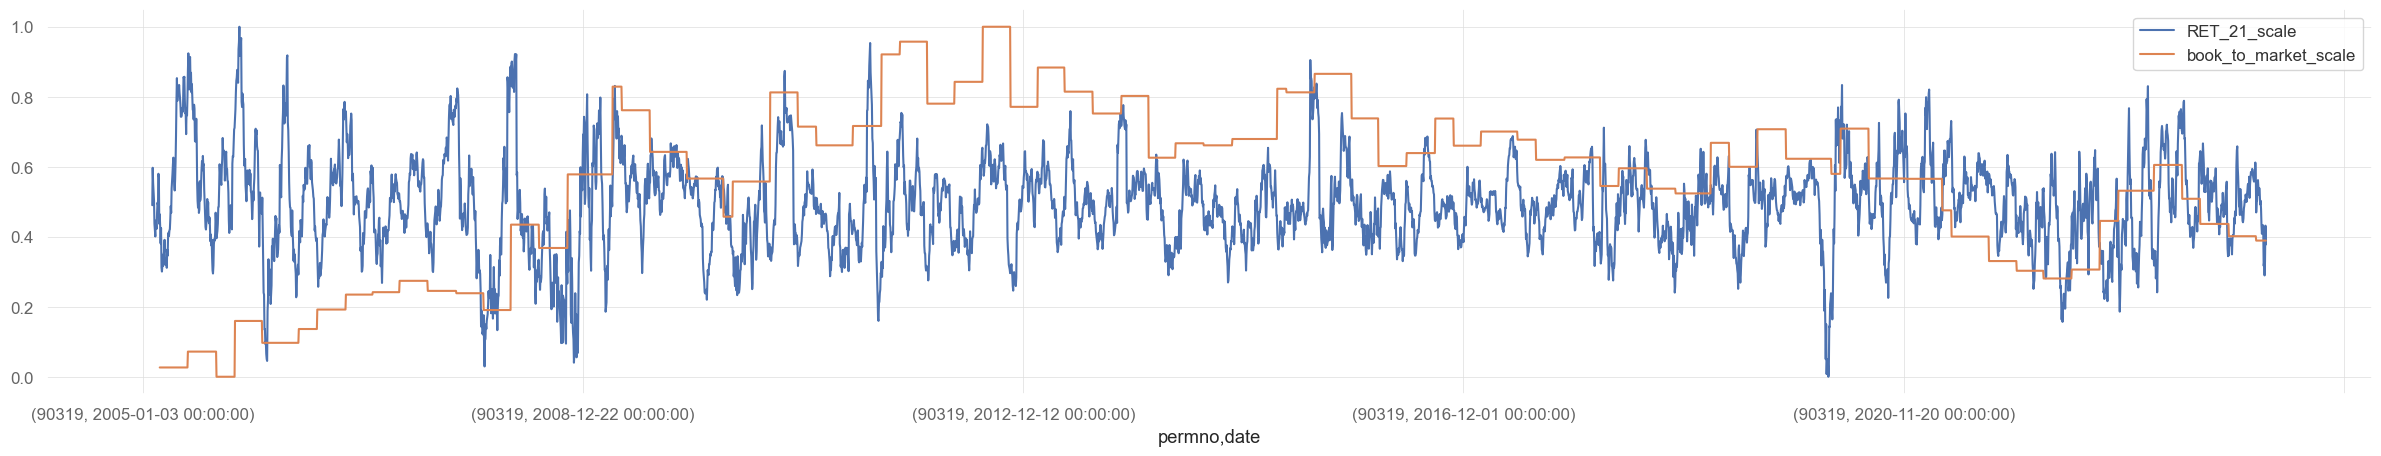



                      book_to_market_scale  RET_21_scale
book_to_market_scale              1.000000      0.026248
RET_21_scale                      0.026248      1.000000 

                      book_to_market_scale  RET_21_scale
book_to_market_scale              1.000000      0.139423
RET_21_scale                      0.139423      1.000000 

                      book_to_market_scale  RET_21_scale
book_to_market_scale              1.000000      0.047324
RET_21_scale                      0.047324      1.000000


In [168]:
ticker = 'GOOGL'
window = 21
style = 'book_to_market'
split_date = '2016-01-01'
ohclv, fundq = load_data(ticker)
fundq = value(fundq)
googl_analysis = analysis(ohclv, fundq, style, window, split_date)

META permno: 13407




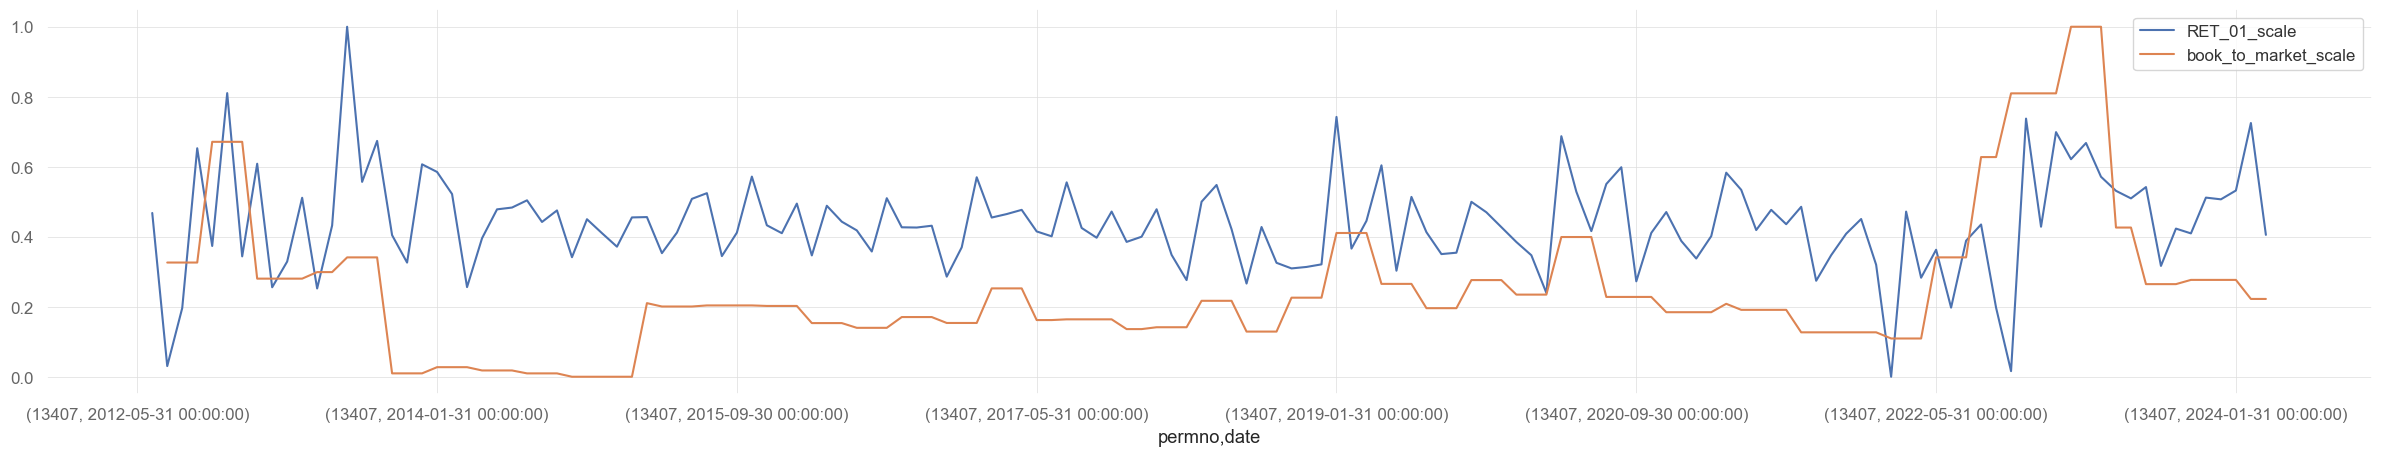



                      book_to_market_scale  RET_01_scale
book_to_market_scale              1.000000      0.120149
RET_01_scale                      0.120149      1.000000 

                      book_to_market_scale  RET_01_scale
book_to_market_scale              1.000000      0.296783
RET_01_scale                      0.296783      1.000000 

                      book_to_market_scale  RET_01_scale
book_to_market_scale              1.000000      0.208434
RET_01_scale                      0.208434      1.000000


In [280]:
ticker = 'META'
window = 1
style = 'book_to_market'
split_date = '2016-01-01'
ohclv, fundq = load_data(ticker)
fundq = value(fundq)
meta_analysis = analysis(ohclv, fundq, style, window, split_date)

#### Regression

In [285]:
T = [1]
window = 21
ret = f'RET_01'
factor_col = ['book_to_market']
beta_meta = rolling_ols_parallel(data=meta_analysis, ret=ret, factor_data=btm, factor_cols=factor_col, window=window, name=f'meta')
defense = beta_meta[[f'book_to_market_meta_{window}']]
defense.columns = ['beta']
defense = defense.dropna()

In [288]:
meta_defense = meta_analysis.join(defense)

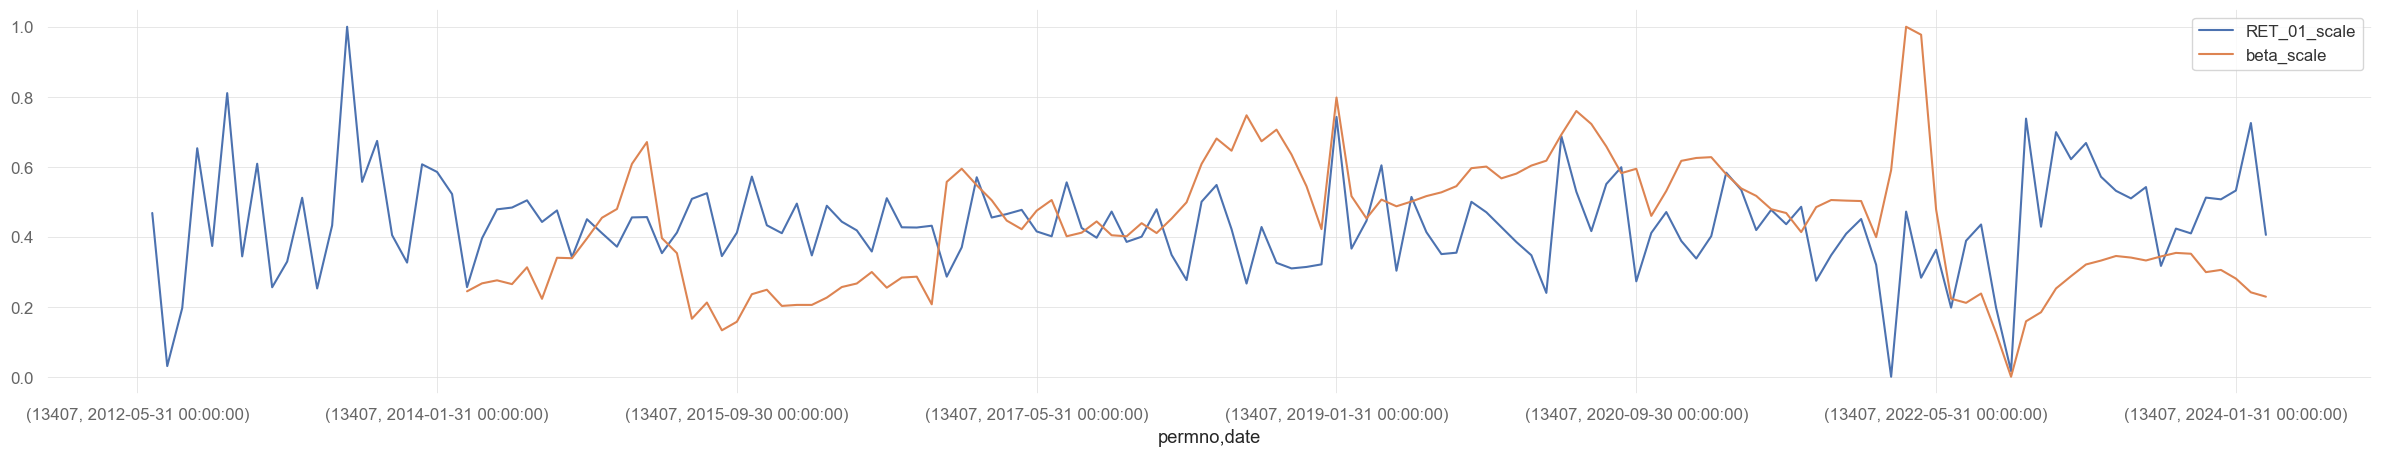

In [290]:
# Return
ret = f'RET_01'
style = 'beta'
scaler = MinMaxScaler()
col_to_scale = [ret, style]
col_change = [f'{ret}_scale', f'{style}_scale']
meta_defense[col_change] = scaler.fit_transform(meta_defense[col_to_scale])
meta_defense[col_change].plot(figsize=(30, 5))
plt.show()